<a href="https://colab.research.google.com/github/santule/microbe-ind/blob/main/notebook/phosphorous_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJECT DESCRIPTION
* Microbial Indicators:
  * Microbial count data (top 50 OTUs) for 54 samples from brisbane.
* Predict Enviornment Stress/ Resilience:
  * Predict Nitrate Classification

#### 0 - INSTALL LIBRARIES

In [ ]:
!pip install boruta
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import RepeatedKFold,cross_val_score,KFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean
from numpy import std
import numpy as np
from sklearn.pipeline import Pipeline
from itertools import compress
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
import seaborn as sns
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from matplotlib import colors as plt_colors

# google drive
from google.colab import drive
drive.mount('/content/drive')
import shap
shap.initjs()

Mounted at /content/drive


#### 1 - PROCESS THE INPUT DATA FILE AND READY FOR ML

In [ ]:
# read the data
otu_data_file = pd.read_csv('/content/drive/MyDrive/UQ/Apoorva/Data_for_ML.csv',index_col=0)
display(otu_data_file.head(5))
print(otu_data_file.shape)

# pivot pandas
otu_data_file_t = otu_data_file.T
# remove special character
otu_data_file_t.columns = otu_data_file_t.columns.str.replace(' ', '')
display(otu_data_file_t.head(5))
print(otu_data_file_t.shape)

,139536_S27,139537_S33,139538_S35,139539_COM,139540_COM,139541_S25,139542_COM,139543_S12,139544_COM,139545_S147,...,139581_S182,139582_S183,139583_S184,139584_S185,139585_S186,139586_S187,139587_S188,139588_S189,139589_S190,139590_S191
OTU1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OTU2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OTU3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OTU4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
OTU5,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


(3247, 54)


,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU3238,OTU3239,OTU3240,OTU3241,OTU3242,OTU3243,Nitrate,Nitrate_classification,Phosphorus,Phosphorus_classification
139536_S27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.01,Normal,0.05,Moderately High(3x)
139537_S33,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,429,0,0.01,Normal,0.05,Moderately High(3x)
139538_S35,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0.01,Normal,0.05,Moderately High(3x)
139539_COM,0,0,0,0,0,0,0,0,2,8,...,0,4,0,0,303,0,0.2,High(10X),0.06,Moderately High(3x)
139540_COM,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,368,0,0.16,High(10X),0.13,High(5X)


(54, 3247)


label data shape (54,)
OTU data shape (54, 3243)


,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU3234,OTU3235,OTU3236,OTU3237,OTU3238,OTU3239,OTU3240,OTU3241,OTU3242,OTU3243
139536_S27,0,0,0,0,0,0,0,0,0,0,...,13,0,0,0,0,0,0,0,0,0
139537_S33,0,0,0,0,0,0,0,0,0,0,...,31,0,0,0,0,3,0,0,429,0
139538_S35,0,0,0,0,0,0,0,0,0,0,...,8,4,0,0,0,2,0,0,0,0
139539_COM,0,0,0,0,0,0,0,0,2,8,...,8,0,0,0,0,4,0,0,303,0
139540_COM,0,0,0,0,0,0,0,0,0,2,...,25,0,0,0,0,0,0,0,368,0


<Axes: ylabel='count'>

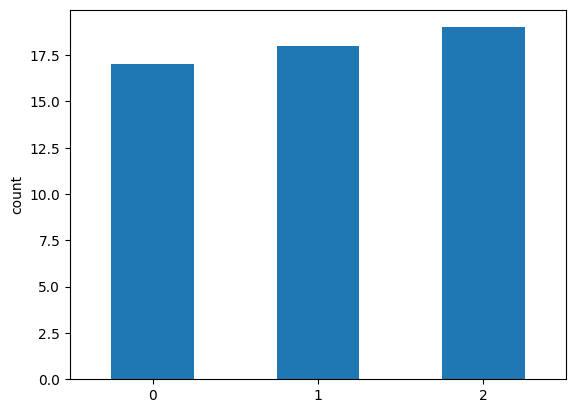

In [ ]:
## LABEL ASSIGNMENT

# Phosphorous category assignment
otu_data_file_t['Phosphorus'] = otu_data_file_t['Phosphorus'].astype(float)
phosphorous_conditions = [
    (otu_data_file_t['Phosphorus'] >= 0.03) & (otu_data_file_t['Phosphorus'] < 0.1),
    (otu_data_file_t['Phosphorus'] >= 0.1) & (otu_data_file_t['Phosphorus'] < 0.15),
    (otu_data_file_t['Phosphorus'] >= 0.15)
    ]

# create a list of the values we want to assign for each condition
phosphorous_values = ['1High_3x', '2High_5x', '3Severe']

# create a new column and use np.select to assign values to it using our lists as arguments
otu_data_file_t['Phosphorus_classification_new'] = np.select(phosphorous_conditions, phosphorous_values)

# convert label to categorical value
labelencoder = LabelEncoder()
otu_data_file_t['Phosphorus_classification_cat'] = labelencoder.fit_transform(otu_data_file_t['Phosphorus_classification_new'])

# label
label_data  = otu_data_file_t['Phosphorus_classification_cat']
print('label data shape',label_data.shape)

# Remove labels
otu_data_file_t_filtered = otu_data_file_t.drop(columns=["Nitrate", "Nitrate_classification","Phosphorus","Phosphorus_classification","Phosphorus_classification_cat","Phosphorus_classification_new"],inplace=False)
print("OTU data shape",otu_data_file_t_filtered.shape)
display(otu_data_file_t_filtered.head(5))

label_data.value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count')


In [ ]:
 # Filter columns by abundance criteria
otu_filter = 10
otu_data_file_t_filtered = otu_data_file_t_filtered.astype('int')
otu_data_file_t_abundant = otu_data_file_t_filtered[otu_data_file_t_filtered.columns[otu_data_file_t_filtered.sum() >= otu_filter]]
otu_data_file_t_abundant.shape

(54, 2020)

In [ ]:
# Take features from indicator value analysis with p < 0.01

phos_ind_analysis = pd.read_csv('/content/drive/MyDrive/UQ/Apoorva/Indval_analyses_P2_v3.csv',index_col=0)
# remove special character
phos_ind_analysis.index = phos_ind_analysis.index.str.replace(' ', '')


# remove special character
ind_features = list(phos_ind_analysis.index.str.replace(' ', ''))
otu_data_file_t_abundant = otu_data_file_t_abundant[ind_features]
print(otu_data_file_t_abundant.shape)

(54, 34)


In [ ]:
# OTU Full name file lookup creation
otu_full_name_file_df = pd.read_csv('/content/drive/MyDrive/UQ/Apoorva/OTU_ID_fullname_lookup.csv')

otu_full_name_file_df.index = otu_full_name_file_df['OTU_ID']

display(otu_full_name_file_df.head(5))

otu_name_dict = otu_full_name_file_df['Short_name'].to_dict()
otu_name_dict['OTU380']

,OTU_ID,Short_name,Short_name.1,ConsensusLineage,ConsensusLineage.1,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
OTU_ID,,,,,,,,,,
OTU1,OTU1,(Aenigmatarchaeales);JAFGAZ01,(o__Aenigmatarchaeales);JAFGAZ01,d__Archaea; p__Aenigmatarchaeota; c__Aenigmata...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__Aenigmatarchaeales,f__Aenigmatarchaeaceae,JAFGAZ01
OTU2,OTU2,(Aenigmatarchaeales);unclassified,(o__Aenigmatarchaeales);unclassified,d__Archaea; p__Aenigmatarchaeota; c__Aenigmata...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__Aenigmatarchaeales,f__Aenigmatarchaeaceae,unclassified
OTU3,OTU3,(Aenigmatarchaeales);,(o__Aenigmatarchaeales);,d__Archaea; p__Aenigmatarchaeota; c__Aenigmata...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__Aenigmatarchaeales,unclassified,NaN
OTU4,OTU4,(CG10238-14);JABABT01,(o__CG10238-14);JABABT01,d__Archaea; p__Aenigmatarchaeota; c__Aenigmata...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__CG10238-14,f__SCSR01,JABABT01
OTU5,OTU5,(CG10238-14);unclassified,(o__CG10238-14);unclassified,d__Archaea; p__Aenigmatarchaeota; c__Aenigmata...,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__CG10238-14,f__SCSR01,unclassified


'(Propionibacteriales);unclassified'

#### 2 - NESTED CV - RANDOM FOREST AND KNN MODEL PERFORMANCE ESTIMATION

##### 2.1 - CROSS VALIDATION - ESTIMATE MODEL PERFORMANCE ( KNN)

In [ ]:
## CV FOR KNN CLASSIFIER - MODEL PERFORMANCE

# create a CV KFOLD
cv_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

# define the model pipeline for inner fold - scale, rfe, classifier
cv_model_pipeline = Pipeline([ ('vt' ,   VarianceThreshold()),
                               ('scale', StandardScaler()),
                               ('knn',   KNeighborsClassifier())])

# evaluate model
scores = cross_val_score(cv_model_pipeline, otu_data_file_t_abundant, label_data, scoring='accuracy', cv=cv_kfold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.829 (0.154)


##### 2.2 - CROSS VALIDATION - ESTIMATE MODEL PERFORMANCE ( RANDOM FOREST)

In [ ]:
## CV FOR RANDOM FOREST CLASSIFIER - CHOOSE FEATURES AND NUMBER OF ESTIMATORS

# create a CV KFOLD
cv_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

# define the model pipeline for inner fold - scale, rfe, classifier
cv_model_pipeline = Pipeline([ ('vt' , VarianceThreshold()),
                               ('bt',  BorutaPy(verbose=0,estimator=RandomForestClassifier(random_state=1),n_estimators='auto',max_iter=100)),
                               ('rfc', RandomForestClassifier(random_state=1))])

# evaluate model
scores = cross_val_score(cv_model_pipeline, otu_data_file_t_abundant, label_data, scoring='accuracy', cv=cv_kfold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.849 (0.141)


#### 3 - Train Random Forest on all dataset using Boruta for feature selection

In [ ]:
# let's initialize a RF model
model = RandomForestClassifier(random_state=1)

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=0,
    estimator=model,
    n_estimators='auto',
    max_iter=100,  # number of iterations to perform,
    random_state=20
)

# train Boruta
feat_selector.fit(np.array(otu_data_file_t_abundant), np.array(label_data))

# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", otu_data_file_t_abundant.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  OTU254  - Ranking:  1
Passes the test:  OTU611  - Ranking:  1
Passes the test:  OTU897  - Ranking:  1
Passes the test:  OTU899  - Ranking:  1
Passes the test:  OTU2028  - Ranking:  1
Passes the test:  OTU2030  - Ranking:  1
Passes the test:  OTU2039  - Ranking:  1
Passes the test:  OTU2045  - Ranking:  1
Passes the test:  OTU2168  - Ranking:  1
Passes the test:  OTU2172  - Ranking:  1
Passes the test:  OTU2173  - Ranking:  1
Passes the test:  OTU2367  - Ranking:  1
Passes the test:  OTU2426  - Ranking:  1
Passes the test:  OTU2523  - Ranking:  1
Passes the test:  OTU2546  - Ranking:  1
Passes the test:  OTU2863  - Ranking:  1
Passes the test:  OTU2963  - Ranking:  1


In [ ]:
# Train Ramdom Forest on full training data and list feature importance
boruta_features = list(otu_data_file_t_abundant.columns[feat_selector.support_])
print("Total Features used:",len(boruta_features))
model_pipeline_bt = Pipeline([('rfc', RandomForestClassifier(random_state=1))])
model_pipeline_bt.fit(otu_data_file_t_abundant[boruta_features],label_data)


Total Features used: 17


Pipeline(steps=[('rfc', RandomForestClassifier(random_state=1))])

#### 3 - SHAP FEATURES

In [ ]:
# SHAP FEATUREE EXPLAINING TARGET VARIABLE
explainer   = shap.Explainer(model_pipeline_bt.named_steps["rfc"],seed=1)
shap_values = explainer.shap_values(otu_data_file_t_abundant[boruta_features])
shap_values[0].shape

(54, 17)

In [ ]:
# SHAP FEATUREE IMPORTANCE
vals= np.abs(shap_values).mean(0).mean(0)
feature_importance = pd.DataFrame(list(zip(boruta_features,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
5,OTU2030,0.049007
12,OTU2426,0.044229
14,OTU2546,0.041582
3,OTU899,0.039044
16,OTU2963,0.032448
8,OTU2168,0.030356
0,OTU254,0.026931
15,OTU2863,0.026182
1,OTU611,0.025327
2,OTU897,0.024234


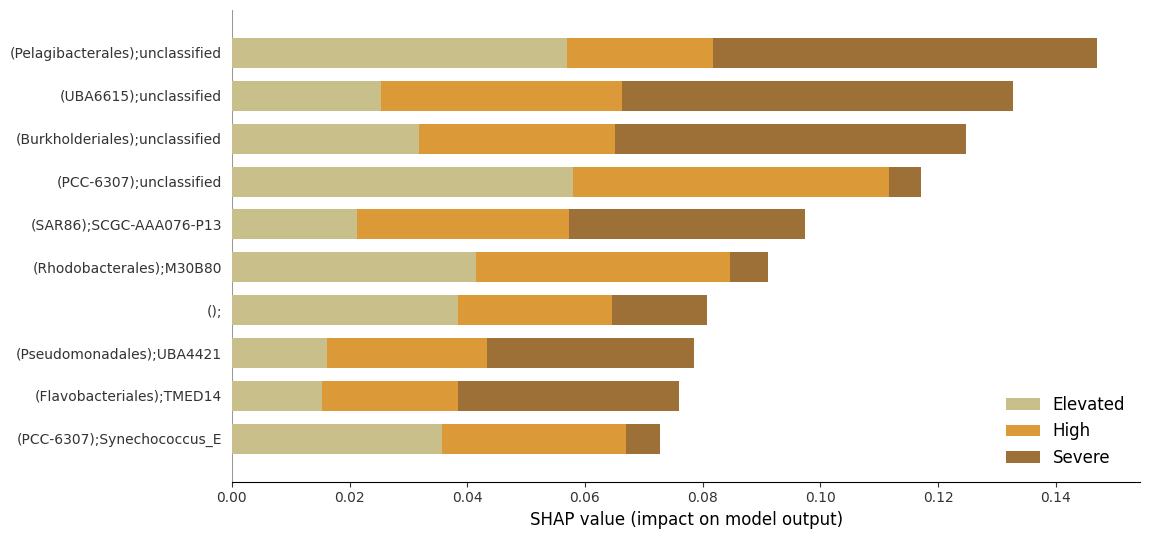

In [ ]:
# colors
classes = ['r', 'g', 'b']
# set RGB tuple per class
colors = [(0.86, 0.60, 0.22), (0.79, 0.75, 0.54), (0.61, 0.44, 0.21)]
# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

# OTU full names
otu_full_feature_names = [otu_name_dict[c] for c in otu_data_file_t_abundant[boruta_features].columns]


# SHAP FEATUREE EXPLAINING TARGET VARIABLE
shap.summary_plot(shap_values, otu_data_file_t_abundant[boruta_features], plot_type='bar', class_inds="original", \
                  class_names=['Elevated', 'High', 'Severe'],feature_names = otu_full_feature_names ,color = cmap,max_display=10,show=False)  #class_names=model_pipeline_bt.named_steps["rfc"].classes_,

# Get the current figure and axes objects. from @GarrettCGraham code
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=10)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
plt.show()

### 5 - MODEL EXPLANATION PER CLASS PREDICTION

#### CLASS 0 - HIGH_3X

   shap_val features
3  0.057966   OTU899
5  0.056999  OTU2030
8  0.041484  OTU2168
0  0.038373   OTU254
2  0.035770   OTU897
Current Label Shown: NORMAL



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


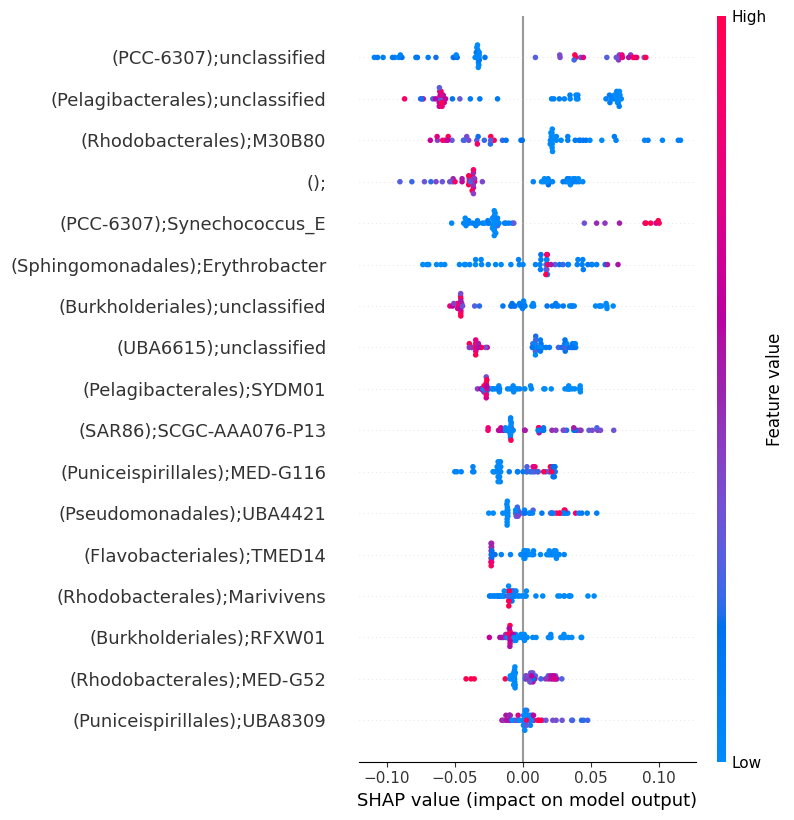

In [ ]:
current_class = 0
print(pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5))
print(f'Current Label Shown: NORMAL\n')
shap.summary_plot(shap_values[current_class],features = otu_data_file_t_abundant[boruta_features], feature_names = otu_full_feature_names,plot_type="dot") #,max_display=5)


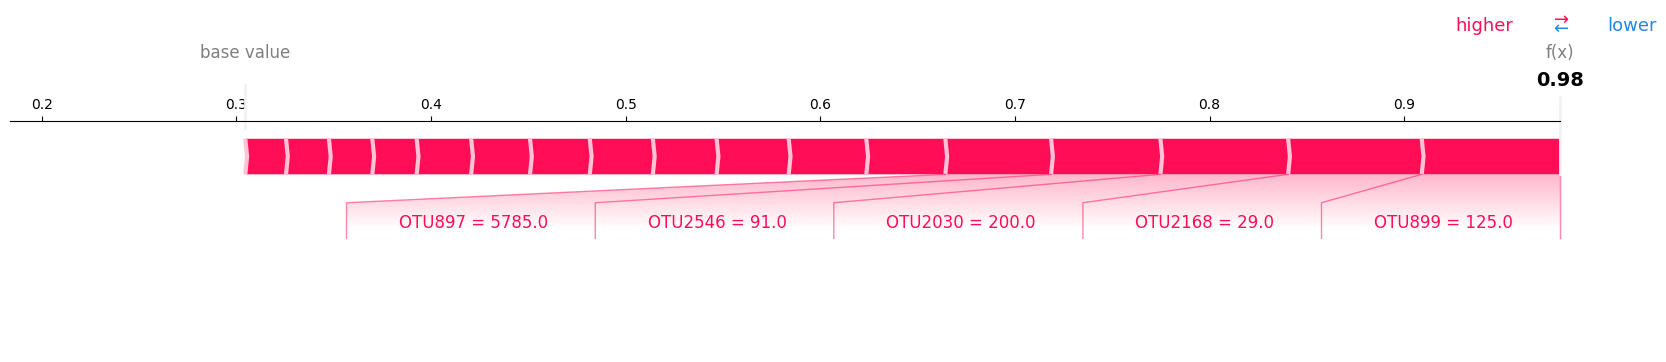

In [ ]:
# EXAMPLE 1
shap.initjs()
shap_value_single = explainer.shap_values(X = otu_data_file_t_abundant[boruta_features].iloc[1:2,:])
shap.force_plot(base_value  = explainer.expected_value[current_class],
                shap_values = shap_value_single[current_class],
                features    = otu_data_file_t_abundant[boruta_features].iloc[1:2,:],
                matplotlib = True,
                contribution_threshold = 0.08
                )

#### CLASS 1 - HIGH_5X

    shap_val features
3   0.053753   OTU899
8   0.043243  OTU2168
12  0.040974  OTU2426
16  0.036052  OTU2963
14  0.033410  OTU2546
Current Label Shown: NORMAL



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


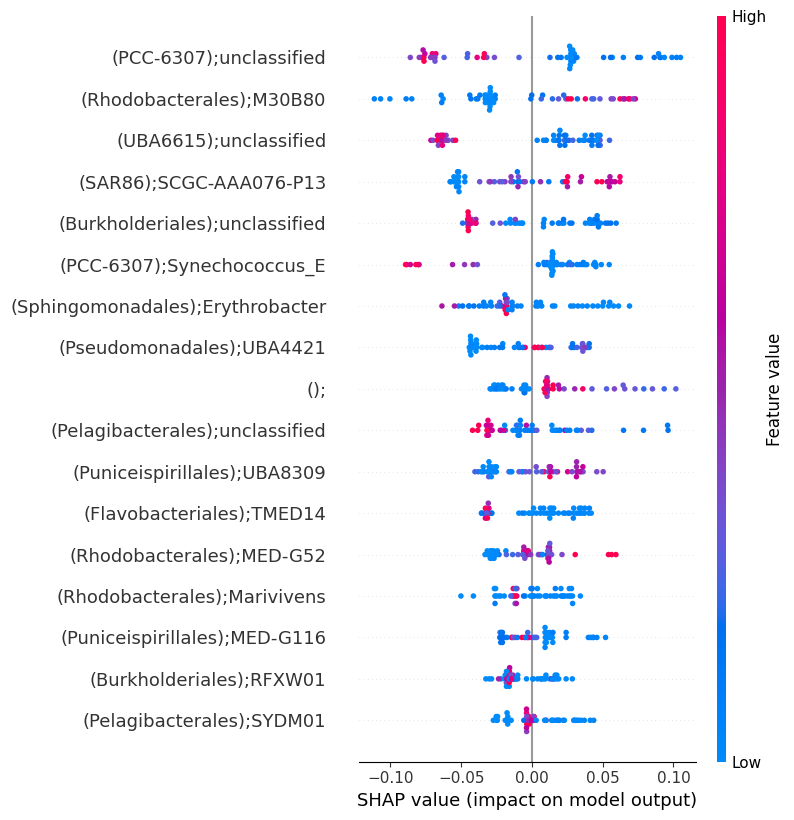

In [ ]:
current_class = 1
print(pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5))
print(f'Current Label Shown: NORMAL\n')
shap.summary_plot(shap_values[current_class],features = otu_data_file_t_abundant[boruta_features], feature_names = otu_full_feature_names, plot_type="dot") #,max_display=5)


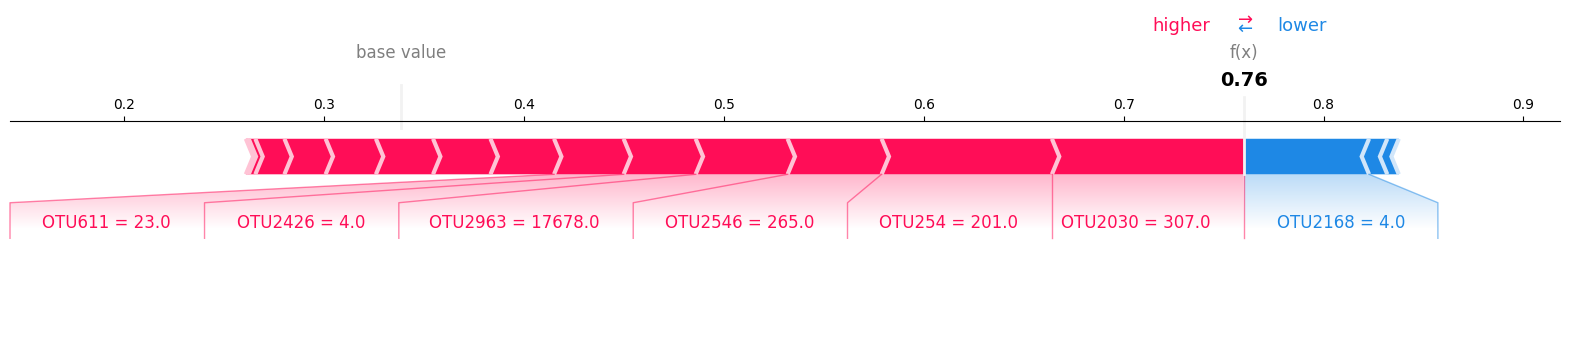

In [ ]:
# EXAMPLE 4
current_class = 1
shap.initjs()
shap_value_single = explainer.shap_values(X = otu_data_file_t_abundant[boruta_features].iloc[4:5,:])

shap.force_plot(base_value  = explainer.expected_value[current_class],
                shap_values = shap_value_single[current_class],
                features    = otu_data_file_t_abundant[boruta_features].iloc[4:5,:],
                matplotlib = True,
                contribution_threshold = 0.08
                )

#### CLASS 2 - SEVERED

    shap_val features
12  0.066344  OTU2426
5   0.065277  OTU2030
14  0.059577  OTU2546
16  0.040108  OTU2963
1   0.037538   OTU611
Current Label Shown: NORMAL



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


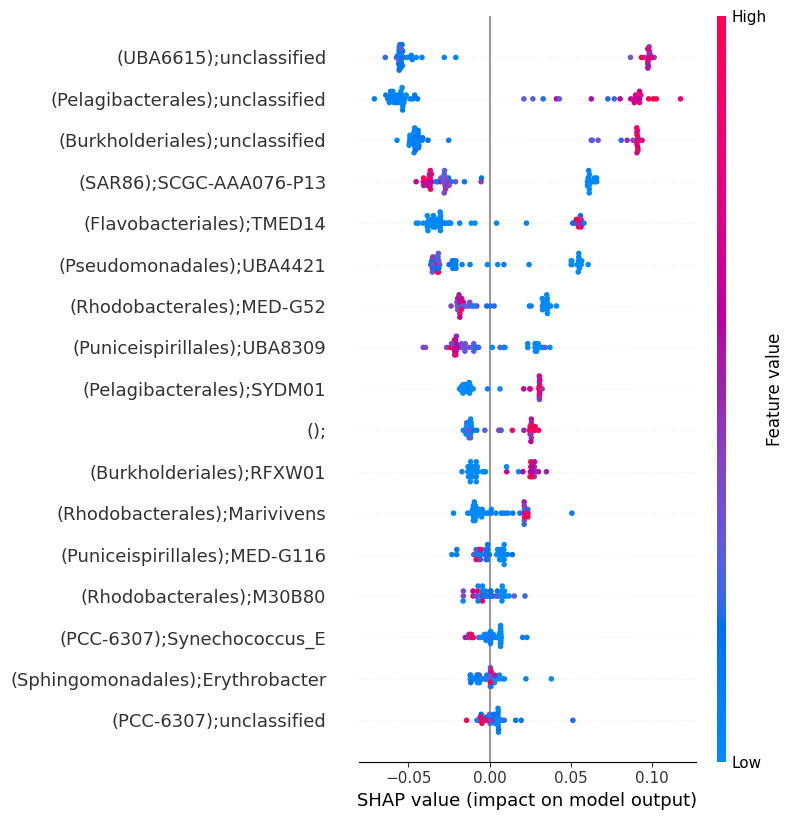

In [ ]:
current_class = 2
print(pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5))
print(f'Current Label Shown: NORMAL\n')
shap.summary_plot(shap_values[current_class],features = otu_data_file_t_abundant[boruta_features], plot_type="dot",feature_names = otu_full_feature_names) #,max_display=5)

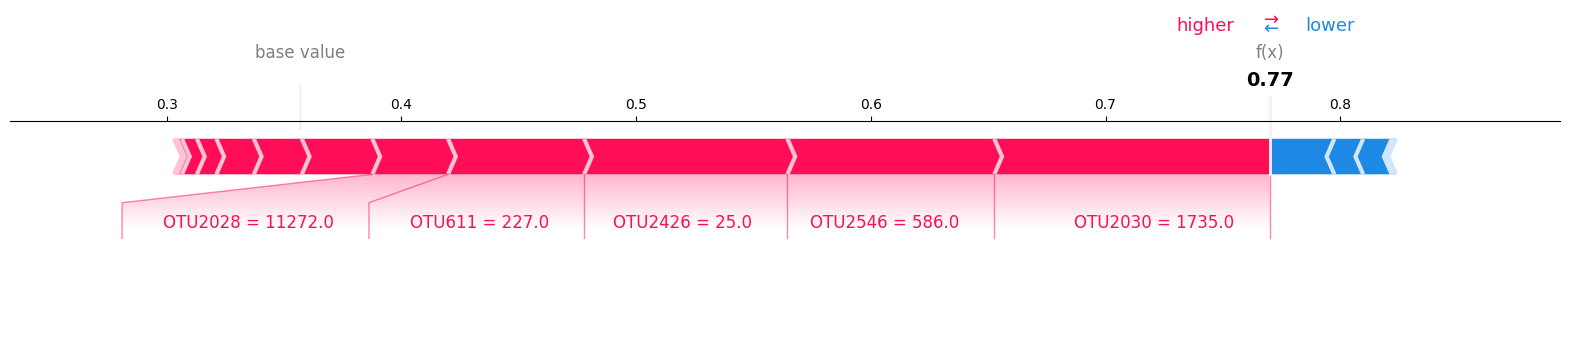

In [ ]:
# EXAMPLE 6
current_class = 2
shap.initjs()
shap_value_single = explainer.shap_values(X = otu_data_file_t_abundant[boruta_features].iloc[6:7,:])

shap.force_plot(base_value  = explainer.expected_value[current_class],
                shap_values = shap_value_single[current_class],
                features    = otu_data_file_t_abundant[boruta_features].iloc[6:7,:],
                matplotlib = True,
                contribution_threshold = 0.08
                )

#### 4 - UNDERSTAND PREDICTIONS

In [ ]:
# get all the data

# top 10 BT features
shap_top_10_features = list(feature_importance['col_name'].head(10))
df_rf = pd.DataFrame(otu_data_file_t_abundant[shap_top_10_features])
df_rf['true_label']      = label_data
df_rf['true_names']      = labelencoder.classes_[df_rf['true_label']]
df_rf['predicted_label'] = model_pipeline_bt.predict(otu_data_file_t_abundant[boruta_features])
df_rf.head(50).sort_values(by='true_names')

,OTU2030,OTU2426,OTU2546,OTU899,OTU2963,OTU2168,OTU254,OTU2863,OTU611,OTU897,true_label,true_names,predicted_label
139536_S27,109,7,64,129,7148,66,70,130,16,6319,0,1High_3x,0
139558_S160,141,6,153,75,6568,35,70,633,63,285,0,1High_3x,0
139557_S159,238,12,151,116,9603,50,49,612,78,231,0,1High_3x,0
139556_S158,253,9,44,186,19298,18,48,1544,109,946,0,1High_3x,0
139555_S157,246,18,44,238,24696,57,94,2117,77,1675,0,1High_3x,0
139554_S156,119,15,97,491,3124,95,79,4102,22,4008,0,1High_3x,0
139565_S166,83,19,83,537,2304,469,68,1937,0,18800,0,1High_3x,0
139566_S167,122,7,144,240,3260,624,44,3264,2,13681,0,1High_3x,0
139560_S161,240,5,131,80,8169,34,89,750,43,645,0,1High_3x,0
139574_S175,152,13,255,167,6746,151,56,274,65,11428,0,1High_3x,0
